<a href="https://colab.research.google.com/github/lirianenogueira/classificadores_decisoes/blob/main/Classificador_versao3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Preparação do ambiente***



In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import nltk
import string 
import seaborn as sns 
import matplotlib.pylab as plt



from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from unicodedata import normalize
from numpy.ma.core import arange
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from seaborn import matrix
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from matplotlib.ticker import FuncFormatter


nltk.download('punkt')
nltk.download('stopwords', force=True,)
nltk.download('rslp')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

***Adição do dataset***

In [2]:
#Carregando o arquivo csv
drive.mount('/content/drive')
!mkdir -p "/content/drive/My Drive/Colab Notebooks/Decisoes"
!wget -P "/content/drive/My Drive/Colab Notebooks/Decisoes" https://github.com/lirianenogueira/classificadores_decisoes/blob/main/Decisoes.csv
filename='/content/drive/MyDrive/Colab Notebooks/Decisoes.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2022-07-01 01:50:11--  https://github.com/lirianenogueira/classificadores_decisoes/blob/main/Decisoes.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/drive/My Drive/Colab Notebooks/Decisoes/Decisoes.csv.4’

Decisoes.csv.4          [ <=>                ] 681.32K  --.-KB/s    in 0.09s   

2022-07-01 01:50:12 (7.82 MB/s) - ‘/content/drive/My Drive/Colab Notebooks/Decisoes/Decisoes.csv.4’ saved [697668]



In [3]:
#Carregando o dataset
dataset = pd.read_csv(filename,delimiter=';',encoding='latin1')
dataset.head(-20)

,Decisao,Tipo
0,"3. ISSO POSTO, JULGO PROCEDENTE a pretensão de...",1
1,"ISSO POSTO, JULGO PROCEDENTE a pretensão desta...",1
2,"ISSO POSTO, JULGO PARCIALMENTE PROCEDENTE a pr...",1
3,"ISSO POSTO, JULGO PROCEDENTE a pretensão desta...",1
4,"3. ISSO POSTO, JULGO PROCEDENTE a pretensão de...",1
...,...,...
546,"Isso posto, DEFIRO O PEDIDO DE TUTELA PROVISÓR...",1
547,"Posto isso, ausentes os requisitos do art. 300...",0
548,"Posto isso, ausentes os requisitos do art. 300...",0
549,"Posto isso, ausentes os requisitos do art. 300...",0


***Tratamento do dataset***

In [ ]:
# Conferindo a quantidade de linhas e colunas
print("Formato do dataset {}".format(dataset.shape))
print(dataset.sample(5))

# Verificando a existencia de dados nulos no dataset.
print(dataset.isnull().sum())

# Separando as variaveis 
x_decisoes = dataset['Decisao'].values.astype('U')
y_tipo = dataset.Tipo.values.astype('int32') #variavel de resposta

#print(x_decisoes)
#print(y)

#Gerando lista de Stop Words em português
stop_words = stopwords.words('portuguese') + list(string.punctuation)
rslpsstemmer = RSLPStemmer()

print('Stop Words: ', stop_words)

#tratando o conjunto de decisoes

#limpando as decisoes
all_words = []
decisoes_words = []
for item in x_decisoes:
    # separando em palavras
    tokens = word_tokenize(item) 
    # removendo todos os tokens que não são alfabetico
    words = [word for word in tokens if word.isalpha()]
    # removendo as stopwords
    words = [word for word in words if not word in stop_words] 
    # remove acentuacao
    words = [normalize('NFKD', word).encode('ASCII', 'ignore').decode('ASCII') for word in words]
    [all_words.append(word) for word in words]
    decisoes_words.append(words)

#separando as classes
decisoes_indeferidas = dataset[dataset.Tipo==0.0] 
decisoes_deferidas = dataset[dataset.Tipo==1.0] 
decisoes_indeferidas.head(-5)

***Tranformação dos dados***

In [5]:
# transformando texto em um vetor com base na frequência (contagem) de cada palavra que ocorre em todo o texto
bow_vectorizer = CountVectorizer(max_df=0.9, min_df=1, analyzer='word')


# percorrendo a lista_decisoes e criando uma unica lista separada por virgula
bow = []
for posicao in range(len(decisoes_words)):     # por índice
    x = ' '.join(decisoes_words[posicao])
    bow.append(x)

# Gerando matriz de vetores de palavras
X_decisoes = bow_vectorizer.fit_transform(bow)


***Validação cruzada***

In [24]:
#instanciando os objetos das classes
logReg = LogisticRegression(C= 0.1, solver='lbfgs', multi_class='multinomial', random_state=21) # parâmetros antes do ajuste: solver='lbfgs', multi_class='multinomial', random_state=21
classificador_SVM = svm.SVC(C= 100, gamma= 0.0001, kernel= 'rbf') # parâmetros antes do ajuste: classificador_SVM = svm.SVC(C=1.0)
naive_bayes = MultinomialNB(alpha=0.01) #parâmetros antes do ajuste: MultinomialNB()
knn = KNeighborsClassifier(n_neighbors=6, weights = 'uniform')  # parâmetros antes do ajuste: n_neighbors=3 
mlp = MLPClassifier(hidden_layer_sizes=(150,), activation="logistic", max_iter=200,alpha = 0.01, solver ='sgd', tol = 1e-9, learning_rate_init=.01) #parâmetros antes do ajuste: (hidden_layer_sizes=(50,), activation="logistic", max_iter=400 *****hidden_layer_sizes = quantidade de neurônios / função de ativação = logística / max_iter define o máximo de interacoes


In [17]:
"""
#Instanciamento incial - antes dos ajustes
logReg = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=21) # parâmetros antes do ajuste: solver='lbfgs', multi_class='multinomial', random_state=21
classificador_SVM = svm.SVC(C= 1) # parâmetros antes do ajuste: classificador_SVM = svm.SVC(C=1.0)
naive_bayes = MultinomialNB() #parâmetros antes do ajuste: MultinomialNB()
knn = KNeighborsClassifier(n_neighbors=3)  # parâmetros antes do ajuste: n_neighbors=3 
mlp = MLPClassifier(hidden_layer_sizes=(50,), activation="logistic", max_iter=400) #parâmetros antes do ajuste: (hidden_layer_sizes=(50,), activation="logistic", max_iter=400 *****hidden_layer_sizes = quantidade de neurônios / função de ativação = logística / max_iter define o máximo de interacoes
"""

In [25]:
#estratificando, onde K — Significa o número de subdivisões (iguais) que nós fizemos: K = 5; Fold — Significa cada um dos blocos de cada K.
#utilizando o StratifiedKFold para estratificar 
kFold = model_selection.StratifiedKFold(n_splits=5)
#criando dicionario para guardar predição para todos os exemplos do conjunto a medida que estiver rodando a validação cruzada
predicted_classes = dict() 
#associando um vetor de numpy todo preenchido com zeros, cujo tambanho (numero de posições) é o tamanho do shape do y_tipo
#criando vetores para guardar os valores de classes preditas por cada modelo para cada um dos 571 exemplos do dataset. O dataset.Tipo guarda a classe real
predicted_classes['logReg'] = np.zeros(y_tipo.shape[0]) 
predicted_classes['classificador_SVM'] = np.zeros(y_tipo.shape[0])
predicted_classes['naive_bayes'] = np.zeros(y_tipo.shape[0])
predicted_classes['knn'] = np.zeros(y_tipo.shape[0])
predicted_classes['mlp'] = np.zeros(y_tipo.shape[0])


In [ ]:
#verificando a separação de treino e teste feita pelo K Fold
for train, test in kFold.split(X_decisoes, y_tipo):
  print('Treino:',train)
  print('Teste:',test)

In [27]:
#dividindo o conjundo de dados em treino e teste em subconjuntos, separados pelo K Fold 
for train, test in kFold.split(X_decisoes, y_tipo):
  X_decisoes_train,  y_tipo_train = X_decisoes[train], y_tipo[train]
  X_decisoes_test, y_tipo_test = X_decisoes[test], y_tipo[test]
  #treinando os algoritmos
  logReg = logReg.fit(X_decisoes_train,  y_tipo_train)
  logReg_predicted = logReg.predict(X_decisoes_test) #tem a classe predita para todos os exemplos do conjunto de testes
  predicted_classes['logReg'][test] = logReg_predicted #acessando o dicionario e preenchendo com as classes preditas 
  
  classificador_SVM = classificador_SVM.fit(X_decisoes_train,  y_tipo_train)
  classificador_SVM_predicted = classificador_SVM.predict(X_decisoes_test) 
  predicted_classes['classificador_SVM'][test] = classificador_SVM_predicted #acessando as posições descritas pelo vetor e preenchendo com as classes preditas 


  naive_bayes = naive_bayes.fit(X_decisoes_train,  y_tipo_train)
  naive_bayes_predicted = naive_bayes.predict(X_decisoes_test) 
  predicted_classes['naive_bayes'][test] = naive_bayes_predicted #acessando as posições descritas pelo vetor e preenchendo com as classes preditas 


  knn = knn.fit(X_decisoes_train,  y_tipo_train)
  knn_predicted = knn.predict(X_decisoes_test) 
  predicted_classes['knn'][test] = knn_predicted #acessando as posições descritas pelo vetor e preenchendo com as classes preditas 


  mlp = mlp.fit(X_decisoes_train,  y_tipo_train)
  mlp_predicted = mlp.predict(X_decisoes_test) 
  predicted_classes['mlp'][test] = mlp_predicted #acessando as posições descritas pelo vetor e preenchendo com as classes preditas 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

***Ajustando os parâmetros dos classificadores***

In [ ]:
# para o logReg

logReg = LogisticRegression()
param_dist = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(logReg,param_grid=param_dist, cv=kFold, scoring='accuracy', refit=False)
grid_search.fit(X_decisoes_train,y_tipo_train)
logRegBestParams = grid_search.best_params_
print("logReg: %s \n\n" % logRegBestParams)

#Resposta: logReg: {'C': 0.1} 

# para o classificador_SVM

classificador_SVM = svm.SVC()
param_dist = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],'kernel': ['rbf']}
grid_search = GridSearchCV(classificador_SVM,param_grid=param_dist, cv=kFold, scoring='accuracy', refit=False)
grid_search.fit(X_decisoes_train,y_tipo_train)
classificador_SVMBestParams = grid_search.best_params_
print("classificador_SVM: %s \n\n" % classificador_SVMBestParams)

#Resposta: classificador_SVM: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'} 


# para o Naive Bayes

naive_bayes = MultinomialNB()
param_dist = {'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}  
grid_search = GridSearchCV(naive_bayes,param_grid=param_dist, cv=kFold, scoring='accuracy', refit=False)
grid_search.fit(X_decisoes_train,y_tipo_train)
naive_bayesBestParams = grid_search.best_params_
print("naive_bayes: %s \n\n" % naive_bayesBestParams)

#Resposta: naive_bayes: {'alpha': 0.01} 


#para o KNN

knn = KNeighborsClassifier()
param_dist = {'n_neighbors': list(np.arange(1, 15)), 'metric':['euclidean'], 'weights':['uniform', 'distance']}
grid_search = GridSearchCV(knn,param_grid=param_dist, cv=kFold, scoring='accuracy', refit=False)
grid_search.fit(X_decisoes_train,y_tipo_train)
knnBestParams = grid_search.best_params_
print("Knn: %s \n\n" % knnBestParams)
#Resposta: Knn: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'} 

#para o MLP

mlp = MLPClassifier()
param_dist = {'hidden_layer_sizes': [150], 'max_iter':[100,200,300,400]}
grid_search = GridSearchCV(mlp,param_grid=param_dist, cv=kFold, scoring='accuracy', refit=False)
grid_search.fit(X_decisoes_train,y_tipo_train)
mlpBestParams = grid_search.best_params_
print("mlp: %s \n\n" % mlpBestParams)

#Resposta: mlp: {'hidden_layer_sizes': 150, 'max_iter': 200} 
#Após isso, foram alterados os parâmetros do código da linha 29 (acima):
"""
#instanciando os objetos das classes
logReg = LogisticRegression(C= 0.1, solver='lbfgs', multi_class='multinomial', random_state=21) # parâmetros antes do ajuste: solver='lbfgs', multi_class='multinomial', random_state=21
classificador_SVM = svm.SVC(C= 100, gamma= 0.0001, kernel= 'rbf') # parâmetros antes do ajuste: classificador_SVM = svm.SVC(C=1.0)
naive_bayes = MultinomialNB(alpha=0.01) #parâmetros antes do ajuste: MultinomialNB()
knn = KNeighborsClassifier(n_neighbors=6, weights = 'uniform')  # parâmetros antes do ajuste: n_neighbors=3 
mlp = MLPClassifier(hidden_layer_sizes=(150,), activation="logistic", max_iter=200,alpha = 0.01, solver ='sgd', tol = 1e-9, learning_rate_init=.01) #parâmetros antes do ajuste: (hidden_layer_sizes=(50,), activation="logistic", max_iter=400 *****hidden_layer_sizes = quantidade de neurônios / função de ativação = logística / max_iter define o máximo de interacoes
"""

***Métricas dos resultados dos classificadores***

In [22]:
Acuracia = []
Recall = []
Precisao = []
F1_Score = []
AUC = []
for classifier in predicted_classes.keys():
  print("=======================================================")
  print("Resultados do classificador %s\n%s\n" %(classifier, metrics.classification_report(y_tipo, predicted_classes[classifier] )))
  print('Classificador:',classifier )
  print("Matriz de confusão: \n%s\n\n\n" % metrics.confusion_matrix(y_tipo, predicted_classes[classifier]))
  Acuracia.append(list((classifier, metrics.accuracy_score(y_tipo, predicted_classes[classifier]))))
  Recall.append(list((classifier, metrics.recall_score(y_tipo, predicted_classes[classifier], average='macro'))))
  Precisao.append(list((classifier, metrics.precision_score(y_tipo, predicted_classes[classifier], average='macro'))) )
  F1_Score.append(list((classifier, metrics.f1_score(y_tipo, predicted_classes[classifier], average='macro'))))
  AUC.append(list((classifier, metrics.f1_score(y_tipo, predicted_classes[classifier]))))
  #print('AUC: %0.2f' % metrics.roc_auc_score(y, predicted_classes[classifier]))
print('Acuracia dos classificadores:', Acuracia)
print('Recall dos classificadores:', Recall)
print('Precisão dos classificadores:', Precisao)
print('F1 score dos classificadores:', F1_Score)
print('AUC dos classificadores:', AUC) #Area debaixa da curva ROC - Em suma, essa métrica nos diz o quanto o modelo é capaz de distinguir as duas classes.


Resultados do classificador logReg
              precision    recall  f1-score   support

           0       0.53      0.86      0.66        87
           1       0.97      0.86      0.91       484

    accuracy                           0.86       571
   macro avg       0.75      0.86      0.78       571
weighted avg       0.90      0.86      0.87       571


Classificador: logReg
Matriz de confusão: 
[[ 75  12]
 [ 67 417]]



Resultados do classificador classificador_SVM
              precision    recall  f1-score   support

           0       0.50      0.79      0.62        87
           1       0.96      0.86      0.91       484

    accuracy                           0.85       571
   macro avg       0.73      0.83      0.76       571
weighted avg       0.89      0.85      0.86       571


Classificador: classificador_SVM
Matriz de confusão: 
[[ 69  18]
 [ 68 416]]



Resultados do classificador naive_bayes
              precision    recall  f1-score   support

           0       

***Gráficos das métricas***

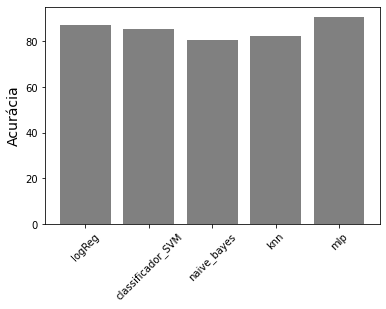

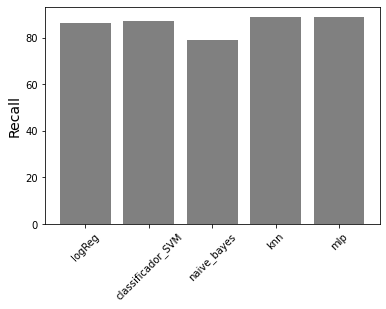

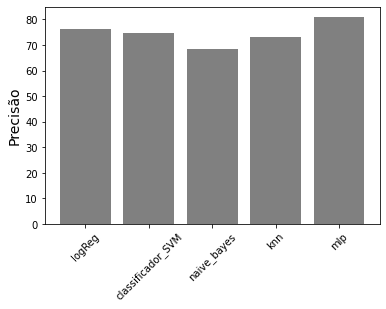

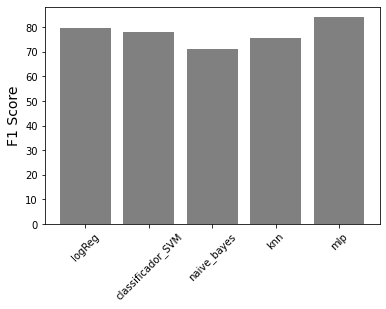

In [28]:
#Gráfico das métricas
Labels_classificadores = []
Valores_Acuracia = []
Valores_Recall = []
Valores_Precisao = []
Valores_F1_Score = []

for classifier in predicted_classes.keys():
  Labels_classificadores.append(classifier)
  Valores_Acuracia.append(metrics.accuracy_score(y_tipo, predicted_classes[classifier])*100)
  Valores_Recall.append(metrics.recall_score(y_tipo, predicted_classes[classifier], average='macro')*100)
  Valores_Precisao.append(metrics.precision_score(y_tipo, predicted_classes[classifier], average='macro')*100)
  Valores_F1_Score.append(metrics.f1_score(y_tipo, predicted_classes[classifier], average='macro')*100)
"""
#conferindo as listas geradas
print('Labels_classificadores:', Labels_classificadores)
print('Valores_Acuracia:', Valores_Acuracia)
print('Valores_Recall:', Valores_Recall)
print('Valores_Precisao:', Valores_Precisao)
print('Valores_F1_Score:', Valores_F1_Score)
"""
"""
#conferindo os valores
print("=======================================================")
print('Acuracia dos classificadores:', Acuracia)
print('Recall dos classificadores:', Recall)
print('Precisão dos classificadores:', Precisao)
print('F1 score dos classificadores:', F1_Score)
"""


plt.bar(Labels_classificadores, Valores_Acuracia, color='grey')
plt.ylabel('Acurácia', fontsize=14)
plt.xticks(Labels_classificadores,Labels_classificadores,rotation=45 )
plt.show()

plt.bar(Labels_classificadores, Valores_Recall, color='grey')
plt.ylabel('Recall', fontsize=14)
plt.xticks(Labels_classificadores,Labels_classificadores,rotation=45 )
plt.show()

plt.bar(Labels_classificadores, Valores_Precisao, color='grey')
plt.ylabel('Precisão', fontsize=14)
plt.xticks(Labels_classificadores,Labels_classificadores,rotation=45 )
plt.show()


plt.bar(Labels_classificadores, Valores_F1_Score, color='grey')
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(Labels_classificadores,Labels_classificadores,rotation=45 )
plt.show()



Classificador: logReg
Matriz de confusão: 
[[ 74  13]
 [ 60 424]]





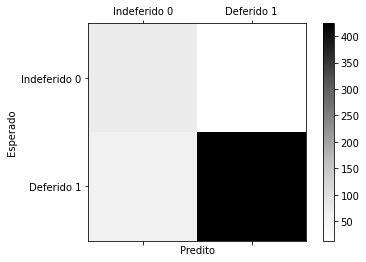

Classificador: classificador_SVM
Matriz de confusão: 
[[ 78   9]
 [ 74 410]]





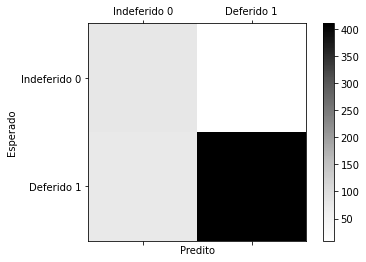

Classificador: naive_bayes
Matriz de confusão: 
[[ 67  20]
 [ 92 392]]





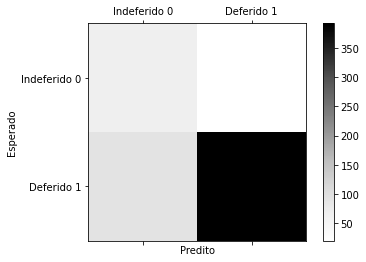

Classificador: knn
Matriz de confusão: 
[[ 85   2]
 [ 98 386]]





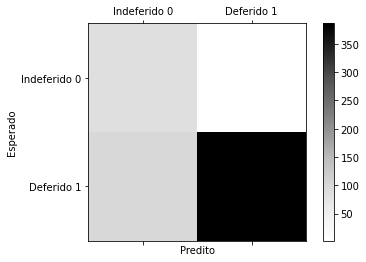

Classificador: mlp
Matriz de confusão: 
[[ 75  12]
 [ 41 443]]





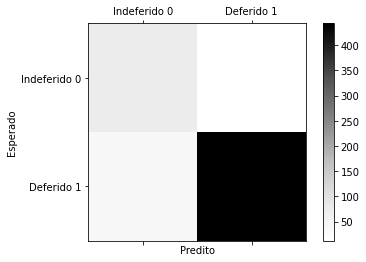

In [34]:
# matrizes de confusão
#print(pd.crosstab(y_train, y_pred, rownames = ["Real"], colnames=["Predito"], margins=True))
"""
mat_conf = pd.crosstab(y_train, y_pred)

# matriz de confusão
conf_matrix = pd.crosstab(y_train, y_pred)
print("Matriz de Confusão do modelo LogisticRegression")
print(conf_matrix)


labels = ['Indeferido 0', 'Deferido 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(mat_conf, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predito')
plt.ylabel('Esperado')
plt.show()
"""
y_tipo_pred=[]
for classifier in predicted_classes.keys():
  print("=======================================================")
  print('Classificador:', classifier)
  print("Matriz de confusão: \n%s\n\n\n" % metrics.confusion_matrix(y_tipo, predicted_classes[classifier]))
  labels = ['Indeferido 0', 'Deferido 1']
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(metrics.confusion_matrix(y_tipo, predicted_classes[classifier]), cmap=plt.cm.Greys)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predito')
  plt.ylabel('Esperado')
  plt.show()







```
HISTÓRICO DOS RESULTADOS:

LOGISTIC REGRESSION

Antes do ajuste:

na linha macro avg: considerando todas as classes a precisão média foi 0.75, o recall médio foi 0.86 e o f1-score médio foi 0.78 e a acurácia foi 0.86

  Matriz de confusão:

  classe predita: 0     1
   classe real 0: 75   12   (acertou 75 exemplos da classe 0 e predisse 12 da   classe 0 como da classe 1)
   classe real 1: 67  417   (acertou 417 exemplos da classe 1 e predisse 67 da   classe 1 como da classe 0)

      
Após ajuste:

na linha macro avg: considerando todas as classes a precisão média foi 0.75, o recall médio foi 0.86 e o f1-score médio foi 0.80 e a acurácia foi 0.87

  Matriz de confusão:

  classe predita: 0     1
   classe real 0: 74   13   
   classe real 1: 60  417 


SUPPORT VECTOR MACHINES

Antes do ajuste:

na linha macro avg: considerando todas as classes a precisão média foi 0.73, o recall médio foi 0.83 e o f1-score médio foi 0.76 e a acurácia foi 0.85

  Matriz de confusão:

   na classe predita: 0     1
      classe real 0: 69   18   
      classe real 1: 68  416

Após ajuste:

na linha macro avg: considerando todas as classes a precisão média foi 0.75, o recall médio foi 0.87 e o f1-score médio foi 0.78 e a acurácia foi 0.85

  Matriz de confusão:
  na classe predita: 0     1
      classe real 0: 78    9   
      classe real 1: 74  410

NAIVE BAYES

Antes do ajuste:

na linha macro avg: considerando todas as classes a precisão média foi 0.67, o recall médio foi 0.77 e o f1-score médio foi 0.69 e a acurácia foi 0.78

  Matriz de confusão:

  classe predita: 0     1
   classe real 0: 66   21   
   classe real 1: 103  381

Após ajuste:

na linha macro avg: considerando todas as classes a precisão média foi 0.69, o recall médio foi 0.79 e o f1-score médio foi 0.71 e a acurácia foi 0.80

  Matriz de confusão:

  classe predita: 0     1
   classe real 0: 67   20   
   classe real 1: 92  392


KNEIGHBORS

Antes do ajuste:

na linha macro avg: considerando todas as classes a precisão média foi 0.72, o recall médio foi 0.85 e o f1-score médio foi 0.71 e a acurácia foi 0.83

  Matriz de confusão:
  
  classe predita: 0     1
   classe real 0: 76   11   
   classe real 1: 86  398

Após ajuste:

na linha macro avg: considerando todas as classes a precisão média foi 0.73, o recall médio foi 0.89 e o f1-score médio foi 0.76 e a acurácia foi 0.82

  Matriz de confusão:


  classe predita: 0     1
   classe real 0: 85   2   
   classe real 1: 98  386


NEURAL NETWORK MPL 

Antes do ajuste:

na linha macro avg: considerando todas as classes a precisão média foi 0.77, o recall médio foi 0.87 e o f1-score médio foi 0.80 e a acurácia foi 0.88

  Matriz de confusão:

  classe predita: 0     1
   classe real 0: 74   13   
   classe real 1: 55  429

Após ajuste:

na linha macro avg: considerando todas as classes a precisão média foi 0.82, o recall médio foi 0.90 e o f1-score médio foi 0.85 e a acurácia foi 0.91

  Matriz de confusão:

  classe predita: 0     1
   classe real 0: 76   11   
   classe real 1: 40  444
```



Para ajuste do SVM BY TYAGIKARTIK4282 AND TRANSLATED BY ACERVO LIMA FROM SVM HYPERPARAMETER TUNING USING GRIDSEARCHCV | ML. LICENSE: CCBY-SA https://acervolima.com/ajuste-de-hiperparametros-svm-usando-gridsearchcv-ml/

Para ajuste do Logistic Regression https://stackoverflow.com/questions/19018333/gridsearchcv-on-logisticregression-in-scikit-learn

Para ajuste do Naive Bayes https://stackoverflow.com/questions/58790707/how-to-perform-grid-search-on-multinomial-naive-bayes-for-a-message-classificati

Métricas: http://neylsoncrepalde.github.io/2019-11-25-regressao_logistica_python/